In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import datetime
!pip show datetime
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
!pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 580 kB/s 
     |████████████████████████████████| 251 kB 9.6 MB/s 


#1시간 단위 데이터 => 5분 단위 데이터

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [ ]:
xdata = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/serner_input/weather.csv')
xdata

,Unnamed: 0,날짜,시간,기온,강수량,풍속,습도,일사,적설량
0,0,2022-06-04,0,20,0.0,3.4,80,0.00000,0.0
1,1,2022-06-04,1,20,0.0,3.4,80,0.00000,0.0
2,2,2022-06-04,2,19,0.0,3.4,80,0.00000,0.0
3,3,2022-06-04,3,19,0.0,3.7,80,0.00000,0.0
4,4,2022-06-04,4,19,0.0,3.8,80,0.00000,0.0
5,5,2022-06-04,5,20,0.0,3.8,85,0.00000,0.0
6,6,2022-06-04,6,20,0.0,4.2,85,0.02628,0.0
7,7,2022-06-04,7,21,0.0,4.3,80,0.42624,0.0
8,8,2022-06-04,8,21,0.0,5.3,80,1.10304,0.0
9,9,2022-06-04,9,23,0.0,5.7,75,1.84176,0.0


In [ ]:
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
import datetime

xdata = xdata.drop(['Unnamed: 0'], axis = 1)
xdata['month'] = pd.to_datetime(xdata['날짜']).dt.month
xdata['day'] = pd.to_datetime(xdata['날짜']).dt.day

df = xdata.drop(['날짜'], axis = 1)

xdata = xdata[['기온', '강수량', '풍속', '습도', '일사', '적설량', 'month', 'day', '시간']]

minute_temp = np.full((24,1), 00)
minute_temp = pd.DataFrame(minute_temp)
minute_temp.columns = ['minute']

second_temp = np.full((24,1), 00)
second_temp = pd.DataFrame(second_temp)
second_temp.columns = ['second']

df = pd.concat([df, minute_temp, second_temp], axis = 1)
df['minute'] = df['minute'].astype(str)
df['second'] = df['second'].astype(str)
df['시간'] = df['시간'].astype(str)

df['time'] = df['시간'] + ':' + df['minute'] + ':' + df['second']
df = df.drop(['시간', 'minute', 'second'], axis = 1)

year_temp = np.full((24,1), 2022)
year_temp = pd.DataFrame(year_temp)
year_temp.columns = ['year']

df = pd.concat([df, year_temp], axis = 1)
df['month'] = df['month'].astype(str)
df['day'] = df['day'].astype(str)
df['year'] = df['year'].astype(str)

df['date'] = df['year'] + '-' + df['month'] + '-' + df['day']
df = df.drop(['year', 'month', 'day'], axis = 1)

df['date'] = pd.to_datetime(df['date']).dt.date
df['time'] = pd.to_datetime(df['time'], format = '%H:%M:%S').dt.time

df['date'] = df['date'].astype(str)
df['time'] = df['time'].astype(str)

df['datetime'] = df['date'] + ' ' + df['time']
df = df.drop(['time', 'date'], axis = 1)

df = df.drop(['풍속', '적설량'], axis = 1)

end_time = df['datetime'][23].split(' ')[0]
end_time = end_time + ' 23:55:00'
df_temp = pd.date_range(start=df['datetime'][0], end=end_time, freq='5T')

print('df_temp: \n',df_temp)

pd.DataFrame(df_temp).to_csv('df_test_temp.csv')

df_temp = pd.DataFrame(df_temp)
df_temp.columns = ['datetime']

df.columns = ['temperature', 'precipitation', 'humidity', 'insolation', 'datetime']

df['datetime'] = pd.to_datetime(df['datetime'])
df_5m = pd.merge(df_temp, df, how='left', on=['datetime'])


listfull = df_5m[df_5m['insolation'].notnull()].index
listnull = df_5m[df_5m['insolation'].isnull()].index

def spl(full_index, null_index, target):
  input_value = list(df_5m[target][full_index]) + [df_5m[target][full_index[-1]]]
  ax1 = list(full_index) + [288]
  ax2 = list(null_index)

  spl_line = splrep(ax1, input_value)
  outputs = splev(ax2, spl_line)

  for i in range(len(outputs)):
    if outputs[i] < 0:
      outputs[i] = 0             #It is impossible data to be negative
  
  return outputs

df_temperature = spl(listfull, listnull, 'temperature')
df_precipitation = spl(listfull, listnull, 'precipitation')
df_humidity = spl(listfull, listnull, 'humidity')
df_insolation = spl(listfull, listnull, 'insolation')

def interpolation(df_, target):
  count = 0
  for i in listnull:
    df_5m[target][i] = df_[count]
    count += 1

interpolation(df_temperature, 'temperature')
interpolation(df_precipitation, 'precipitation')
interpolation(df_humidity, 'humidity')
interpolation(df_insolation, 'insolation')

df_5m.to_csv('df_5m_show.csv')

date_time = pd.to_datetime(df_5m['datetime'])
date_time.to_csv('date_time.csv')
timestamp_s = date_time.map(datetime.datetime.timestamp)
#print('datetime.timestamp : \n',datetime.datetime.timestamp)

#print('timestamp_s : \n', timestamp_s)

day = 24*60*60
year = (365.2425)*day

df_5m['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_5m['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_5m['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_5m['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df_5m = df_5m.drop(['datetime'], axis = 1)
df_5m.info()

df_temp: 
 DatetimeIndex(['2022-06-04 00:00:00', '2022-06-04 00:05:00',
               '2022-06-04 00:10:00', '2022-06-04 00:15:00',
               '2022-06-04 00:20:00', '2022-06-04 00:25:00',
               '2022-06-04 00:30:00', '2022-06-04 00:35:00',
               '2022-06-04 00:40:00', '2022-06-04 00:45:00',
               ...
               '2022-06-04 23:10:00', '2022-06-04 23:15:00',
               '2022-06-04 23:20:00', '2022-06-04 23:25:00',
               '2022-06-04 23:30:00', '2022-06-04 23:35:00',
               '2022-06-04 23:40:00', '2022-06-04 23:45:00',
               '2022-06-04 23:50:00', '2022-06-04 23:55:00'],
              dtype='datetime64[ns]', length=288, freq='5T')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 287
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    288 non-null    float64
 1   precipitation  288 non-null    float64
 2   humidity       288 non-null    float64
 3   insolation     288 non-null    float64
 4   Day sin        288 non-null    float64
 5   Day cos        288 non-null    float64
 6   Year sin       288 non-null    float64
 7   Year cos       288 non-null    float64
dtypes: float64(8)
memory usage: 28.4 KB


In [ ]:
df_5m.to_csv('/content/drive/MyDrive/발전예측/2ndSpline/serner_input/df_5m.csv')

In [ ]:
print(datetime.datetime.now())

2022-06-04 08:25:38.080162


In [ ]:
# datetime을 만듭니다. 
date = pd.Timestamp('2022-06-04 17:30:00')

# 시간대를 지정합니다.
date_in_london = date.tz_localize('Europe/London')

# datetime을 확인합니다.
date_in_london

Timestamp('2022-06-04 17:30:00+0100', tz='Europe/London')

In [ ]:
date_in_london.tz_convert('Africa/Abidjan')

Timestamp('2022-06-04 16:30:00+0000', tz='Africa/Abidjan')

In [ ]:
ax = np.arange(0,288,1)
y1 = np.sin(2 * np.pi * ax / 288)
y2 = np.cos(2 * np.pi * ax / 288)

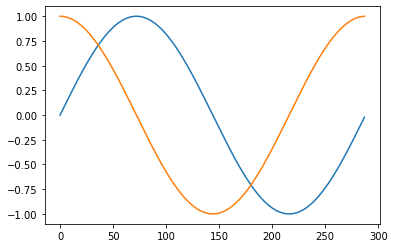

In [ ]:
plt.plot(y1)
plt.plot(y2)

In [ ]:
from datetime import datetime, timezone

def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=timezone.utc).astimezone(tz=None)

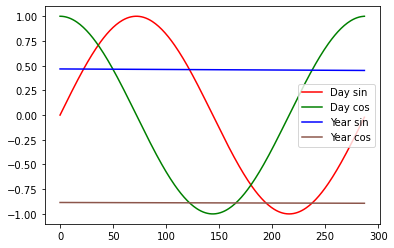

In [ ]:
plt.plot(df_5m['Day sin'], c = 'r', label = 'Day sin')
plt.plot(df_5m['Day cos'], c = 'g', label = 'Day cos')
plt.plot(df_5m['Year sin'], c = 'b', label = 'Year sin')
plt.plot(df_5m['Year cos'], c = 'C5', label = 'Year cos')
plt.legend()
plt.show()

In [ ]:
pip show datetime

In [ ]:
x = [[1,2,3],[2,3,4],[3,4,5]]

In [ ]:
x = pd.DataFrame(x)

In [ ]:
x.columns = ['first', 'second', 'third']

In [ ]:
x

,first,second,third
0,1,2,3
1,2,3,4
2,3,4,5


In [ ]:
index_list = [1,2]

In [ ]:
y = ['two', 'three']

In [ ]:
count = 0
for i in index_list:
  x['first'][i] = y[count]
  count += 1

In [ ]:
x

,first,second,third
0,1,2,3
1,two,3,4
2,three,4,5


In [ ]:
df_5m['insolation'][0]

0.0

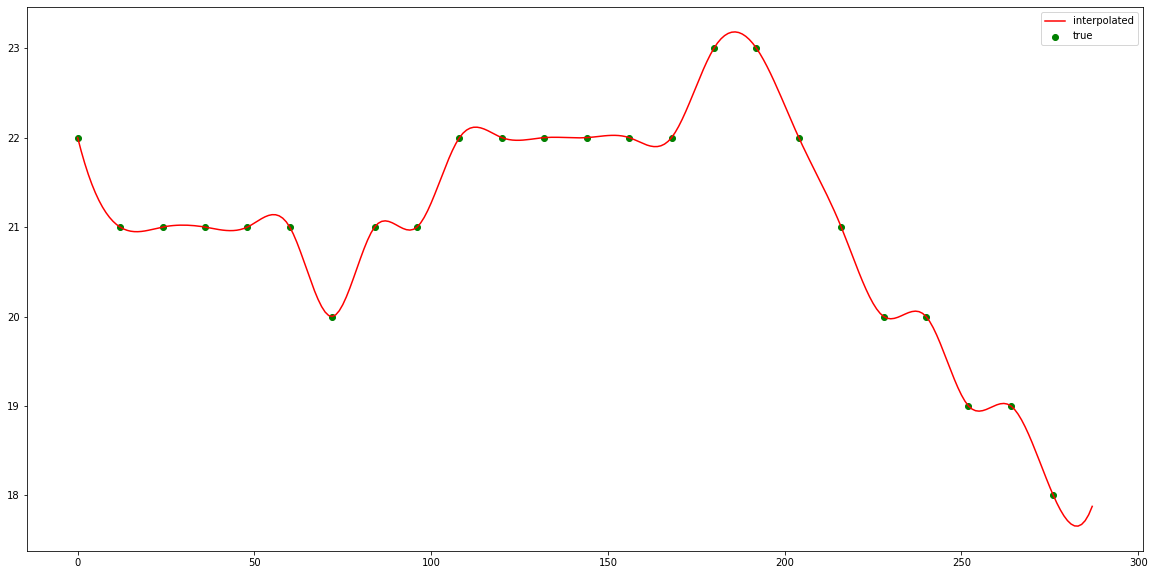

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.plot(df_5m['temperature'], c = 'r', label = 'interpolated')
plt.scatter(listfull, df_5m['temperature'][listfull], c = 'g', label = 'true')
plt.legend()
plt.show()


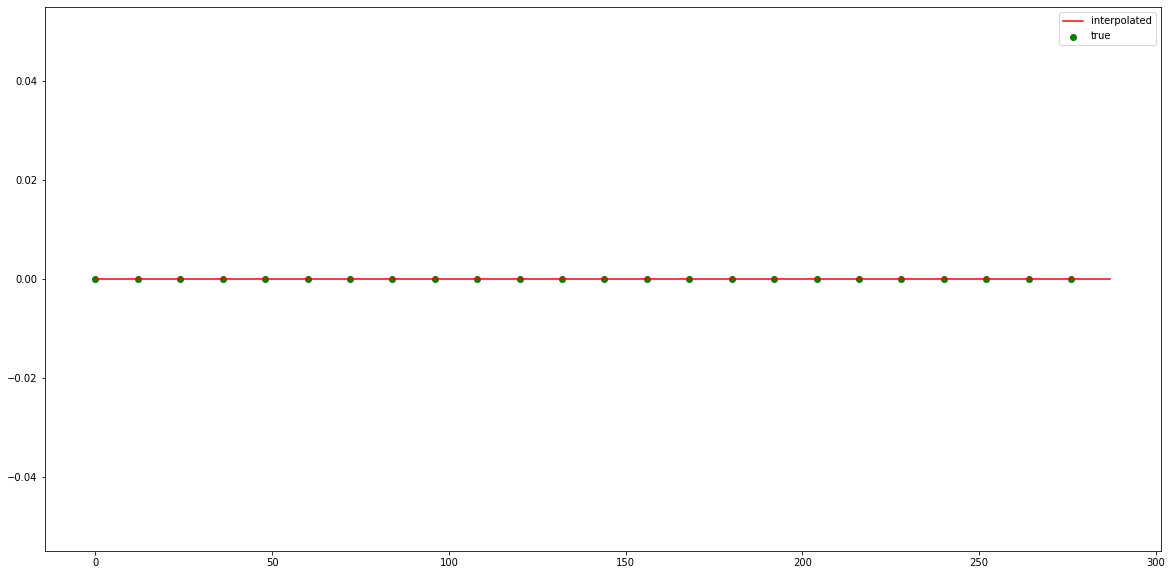

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(df_5m['precipitation'], c = 'r', label = 'interpolated')
plt.scatter(listfull, df_5m['precipitation'][listfull], c = 'g', label = 'true')
plt.legend()
plt.show()

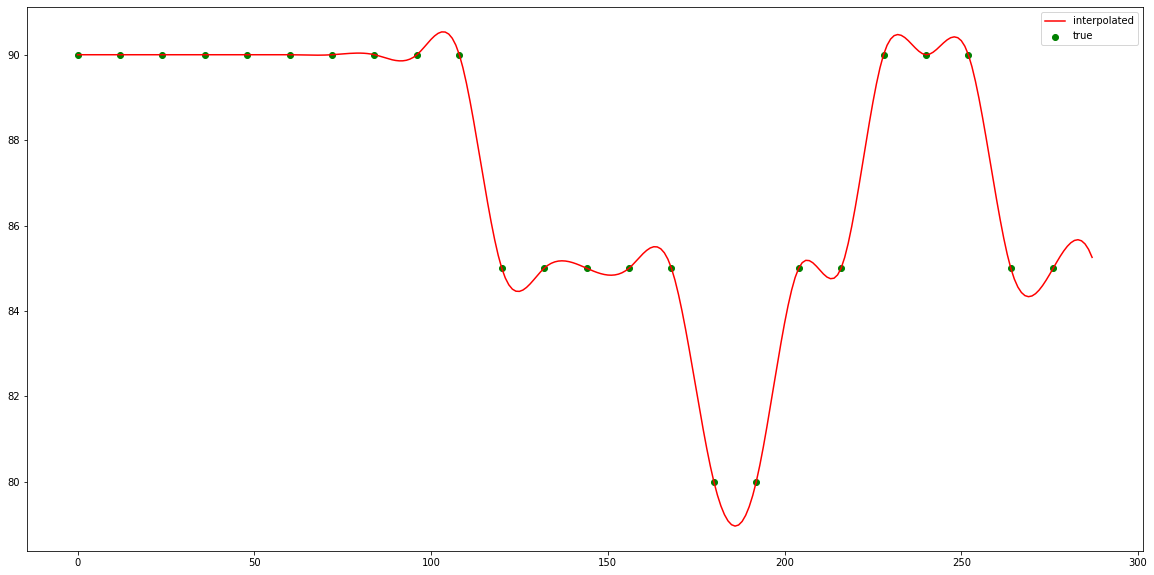

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(df_5m['humidity'], c = 'r', label = 'interpolated')
plt.scatter(listfull, df_5m['humidity'][listfull], c = 'g', label = 'true')
plt.legend()
plt.show()

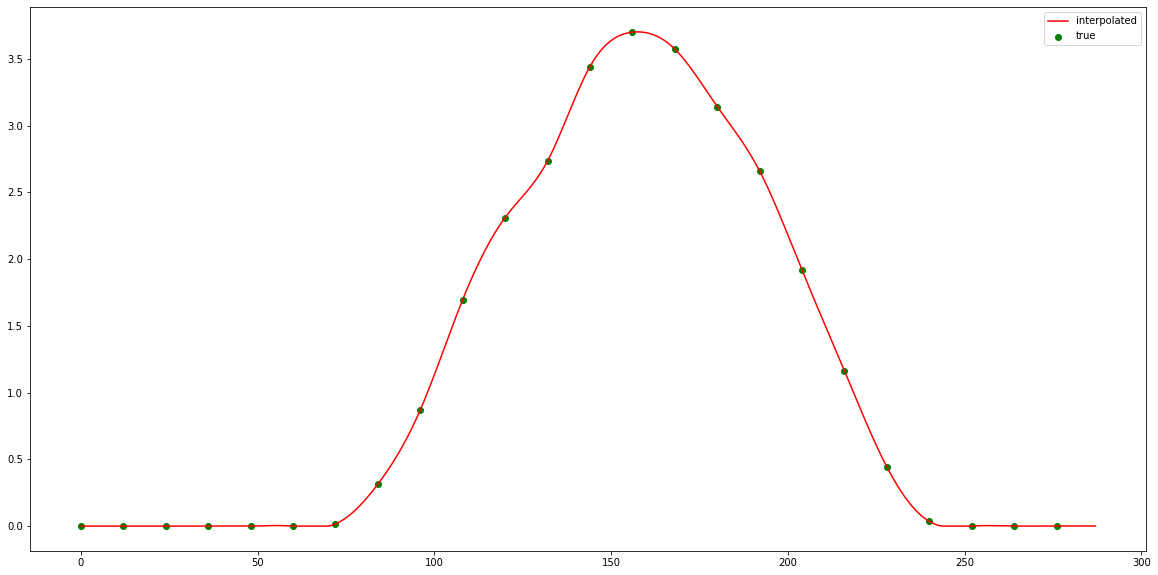

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(df_5m['insolation'], c = 'r', label = 'interpolated')
plt.scatter(listfull, df_5m['insolation'][listfull], c = 'g', label = 'true')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Time of day signal')

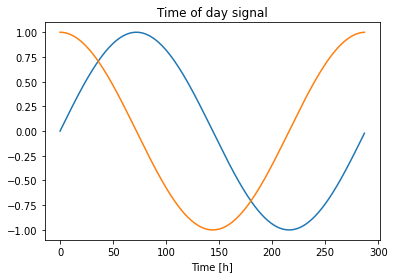

In [ ]:
plt.plot(np.array(df_5m['Day sin'])[:288])
plt.plot(np.array(df_5m['Day cos'])[:288])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of Year signal')

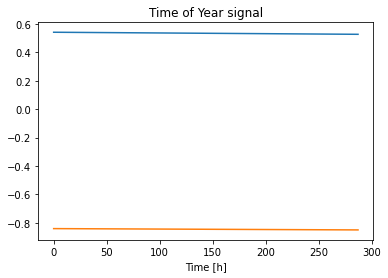

In [ ]:
plt.plot(np.array(df_5m['Year sin'])[:288*365])
plt.plot(np.array(df_5m['Year cos'])[:288*365])
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

#다시 보간
###-한번에 보간하려니 램을 너무 많이 잡아먹어서 세션이 다운됨

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
import datetime

In [ ]:
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
import datetime

In [ ]:
fcst_2020_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2020_fcst_raw.csv')
energy_2020_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2020_energy_raw.csv')
fcst_2021_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2021_fcst_raw.csv')
energy_2021_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2021_energy_raw.csv')

In [ ]:
fcst_2021_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2021_fcst_raw.csv')
fcst_2020_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2020_fcst_raw.csv')

In [ ]:
fcst_2020_raw.isnull().sum()

Unnamed: 0    0
날짜            0
시간            0
기온            0
강수량           0
풍속            0
습도            0
일사            0
일조            0
적설량           0
dtype: int64

In [ ]:
fcst_2021_raw.isnull().sum()

Unnamed: 0    0
날짜            0
시간            0
기온            0
강수량           0
풍속            0
습도            0
일사            0
일조            0
적설량           0
dtype: int64

In [ ]:
energy_2020_raw.isnull().sum()

Unnamed: 0      0
날짜              0
시간              0
공급능력          162
현재부하          162
태양광합계         162
풍력합계          162
기타신재생         162
신재생총합계        162
dtype: int64

In [ ]:
energy_2021_raw.isnull().sum()

Unnamed: 0       0
날짜               0
시간               0
공급능력          1003
현재부하          1003
태양광합계         1003
풍력합계          1003
기타신재생         1003
신재생총합계        1003
dtype: int64

In [ ]:
energy_2020_raw.isnull().sum()

Unnamed: 0      0
날짜              0
시간              0
공급능력          162
현재부하          162
태양광합계         162
풍력합계          162
기타신재생         162
신재생총합계        162
dtype: int64

In [ ]:
sunlight_2021 = energy_2021_raw['태양광합계']
sunlight_2020 = energy_2020_raw['태양광합계']

In [ ]:
sunlight_2021 = pd.DataFrame(sunlight_2021)
sunlight_2020 = pd.DataFrame(sunlight_2020)

In [ ]:
sunlight_2021.columns = ['sunlight']
sunlight_2020.columns = ['sunlight']

In [ ]:
sunlight_2021.isnull().sum()

sunlight    1003
dtype: int64

In [ ]:
sunlight_2020.isnull().sum()

sunlight    162
dtype: int64

In [ ]:
listfull_2021 = sunlight_2021[sunlight_2021.notnull()].index
listfull_2020 = sunlight_2021[sunlight_2021.notnull()].index

listnull_2021 = sunlight_2021[sunlight_2021.isnull()].index
listnull_2020 = sunlight_2021[sunlight_2021.isnull()].index

In [ ]:
ax1 = list(listfull_2021)
ax2 = list(listnull_2021)

In [ ]:
input_2021 = list(sunlight_2021['sunlight'][listfull_2021])

In [ ]:
spl_line_2021 = splrep(ax1, input_2021)

In [ ]:
outputs_2021 = splev(ax2, spl_line_2021)

In [ ]:
ax2

In [ ]:
count = 0
for i in listnull_2021:
  sunlight_2021[i] = outputs_2021[count]
  count += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


#Interpolation for power demand

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
demand_2020 = pd.read_csv("/content/drive/MyDrive/발전예측/2ndSpline/2020_energy_raw.csv", index_col=0, thousands = ',')
demand_2021 = pd.read_csv("/content/drive/MyDrive/발전예측/2ndSpline/2021_energy_raw.csv", index_col=0, thousands = ',')

In [ ]:
demand_2020 = demand_2020['현재부하']
demand_2021 = demand_2021['현재부하']

In [ ]:
demand_2020.columns = ['current_load']
demand_2021.columns = ['current_load']

In [ ]:
print('demand_2020 shape: ', demand_2020.shape)
print('demand_2021 shape: ', demand_2021.shape)

demand_2020 shape:  (105408,)
demand_2021 shape:  (105120,)


In [ ]:
date_2020 = pd.DataFrame()
date_2020['date'] = pd.date_range(start='2020-01-01 00:00', end='2020-12-31 23:55', freq='5T')
date_2021 = pd.DataFrame()
date_2021['date'] = pd.date_range(start='2021-01-01 00:00', end='2021-12-31 23:55', freq='5T')

In [ ]:
print('date_2020 shape : ', date_2020.shape)
print('date_2021 shape : ', date_2021.shape)

date_2020 shape :  (105408, 1)
date_2021 shape :  (105120, 1)


In [ ]:
print(demand_2020.isnull().sum())
print(demand_2021.isnull().sum())

162
1003


In [ ]:
print(demand_2021.head())

0    759000.0
1    752000.0
2    749000.0
3    750000.0
4    740000.0
Name: 현재부하, dtype: float64


In [ ]:
print(demand_2021[demand_2021.isnull()].index)

Int64Index([], dtype='int64')


In [ ]:
demand_2020 = demand_2020.interpolate()
demand_2021 = demand_2021.interpolate()

In [ ]:
demand_2020_1 = pd.concat([demand_2020, demand_2021], axis=0)
demand_2020_1.to_csv("/content/drive/MyDrive/신재생E/demand_2020_1.csv")

#여기서 보간

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
import datetime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
energy_2020_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2020_energy_raw.csv', thousands = ',')
energy_2021_raw = pd.read_csv('/content/drive/MyDrive/발전예측/2ndSpline/2021_energy_raw.csv', thousands = ',')

In [ ]:
energy_2020_raw.drop(['Unnamed: 0'], axis = 1, inplace = True)
energy_2021_raw.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
energy_2020_raw = energy_2020_raw[['날짜', '시간', '태양광합계']]
energy_2021_raw = energy_2021_raw[['날짜', '시간', '태양광합계']]

In [ ]:
energy_2020_raw.columns = ['date', 'time', 'sunlight']
energy_2021_raw.columns = ['date', 'time', 'sunlight']

In [ ]:
energy_2020_raw['date'] = energy_2020_raw['date'].astype(str)
energy_2020_raw['time'] = energy_2020_raw['time'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
energy_2020_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105408 entries, 0 to 105407
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      105408 non-null  object 
 1   time      105408 non-null  object 
 2   sunlight  105246 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.4+ MB


In [ ]:
df_temp_2020 = energy_2020_raw['date'] + ' ' + energy_2020_raw['time']
energy_2020_raw = pd.concat([energy_2020_raw, df_temp_2020], axis = 1)
energy_2020_raw.drop(['date', 'time'], axis = 1, inplace = True)
energy_2020_raw.columns = ['sunlight', 'date']
energy_2020_raw.head()

,sunlight,date
0,0.0,2020-01-01 00:00:00
1,0.0,2020-01-01 00:05:00
2,0.0,2020-01-01 00:10:00
3,0.0,2020-01-01 00:15:00
4,0.0,2020-01-01 00:20:00


In [ ]:
df_temp_2021 = energy_2021_raw['date'] + ' ' + energy_2021_raw['time']
energy_2021_raw = pd.concat([energy_2021_raw, df_temp_2021], axis = 1)
energy_2021_raw.drop(['date', 'time'], axis = 1, inplace = True)
energy_2021_raw.columns = ['sunlight', 'date']
energy_2021_raw.head()

,sunlight,date
0,0.0,2021-01-01 00:00:00
1,0.0,2021-01-01 00:05:00
2,0.0,2021-01-01 00:10:00
3,0.0,2021-01-01 00:15:00
4,0.0,2021-01-01 00:20:00


In [ ]:
df_date_2020 = pd.DataFrame()
df_date_2020['date'] = pd.date_range(start='2020-01-01 00:00', end='2020-12-31 23:55', freq='5T')
df_date_2021 = pd.DataFrame()
df_date_2021['date'] = pd.date_range(start='2021-01-01 00:00', end='2021-12-31 23:55', freq='5T')

In [ ]:
energy_2021_raw['date'] = pd.to_datetime(energy_2021_raw['date'])
energy_2020_raw['date'] = pd.to_datetime(energy_2020_raw['date'])

In [ ]:
df_5m_2021 = pd.merge(df_date_2021, energy_2021_raw, how='left', on=['date'])
df_5m_2020 = pd.merge(df_date_2020, energy_2020_raw, how='left', on=['date'])

In [ ]:
df_5m_2020_toshow = pd.merge(df_date_2020, energy_2020_raw, how='left', on=['date'])

In [ ]:
df_5m_2021.isnull().sum()

date           0
sunlight    1003
dtype: int64

In [ ]:
df_5m_2020.isnull().sum()

date          0
sunlight    162
dtype: int64

In [ ]:
df_5m_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105120 entries, 0 to 105119
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      105120 non-null  datetime64[ns]
 1   sunlight  104117 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 MB


In [ ]:
df_5m_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105408 entries, 0 to 105407
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      105408 non-null  datetime64[ns]
 1   sunlight  105246 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 MB


#df_5m 보간하기

트러블 슈팅 

결측치 위치를 모두 알아내고 한번에 보간하려고 하면 이전 결측치 때문에 splev 함수에 nan값이 들어갈 수 있다.

따라서 결측치가 발생한 앞부분부터 차례대로 보간을 실시해야 함.


In [ ]:
def bunchnull(df, target):
  listnull = df[df[target].isnull()].index
  bunchnull = []
  temp = []
  last_value = listnull[len(listnull)-1]
  for i in range(0,len(listnull)-1):
    if (listnull[i]+1 == (listnull[i+1])):
      print('a',i)
      temp.append(listnull[i])
    elif (listnull[i]+1 < (listnull[i+1])):
      print('t',i)
      temp.append(listnull[i])
      bunchnull.append(temp)
      temp = []
    if (listnull[i+1] == last_value):
      print('o',i)
      temp.append(listnull[len(listnull)-1])
      bunchnull.append(temp)
  return bunchnull

In [ ]:
bunchnull_2020 = bunchnull(df_5m_2020, 'sunlight')
bunchnull_2021 = bunchnull(df_5m_2021, 'sunlight')

a 0
a 1
t 2
a 3
a 4
a 5
t 6
t 7
t 8
t 9
t 10
t 11
t 12
t 13
t 14
t 15
t 16
t 17
t 18
t 19
t 20
t 21
t 22
t 23
t 24
t 25
t 26
t 27
a 28
a 29
a 30
a 31
a 32
t 33
t 34
a 35
a 36
t 37
a 38
a 39
a 40
a 41
t 42
t 43
a 44
a 45
t 46
a 47
t 48
a 49
a 50
t 51
t 52
t 53
a 54
t 55
t 56
t 57
t 58
t 59
t 60
t 61
t 62
a 63
a 64
t 65
a 66
a 67
a 68
a 69
a 70
a 71
a 72
a 73
t 74
a 75
t 76
a 77
t 78
a 79
a 80
a 81
t 82
a 83
a 84
t 85
t 86
t 87
a 88
a 89
a 90
a 91
a 92
a 93
a 94
a 95
a 96
a 97
a 98
a 99
a 100
a 101
a 102
a 103
a 104
a 105
a 106
a 107
a 108
a 109
a 110
a 111
a 112
a 113
a 114
a 115
a 116
a 117
t 118
t 119
t 120
t 121
t 122
t 123
t 124
t 125
t 126
t 127
t 128
t 129
a 130
a 131
a 132
t 133
a 134
a 135
a 136
a 137
t 138
a 139
t 140
t 141
t 142
t 143
t 144
t 145
t 146
t 147
t 148
t 149
t 150
t 151
t 152
t 153
a 154
t 155
t 156
a 157
t 158
a 159
a 160
o 160
t 0
t 1
t 2
t 3
a 4
a 5
a 6
a 7
a 8
t 9
t 10
t 11
a 12
a 13
a 14
a 15
a 16
a 17
a 18
a 19
a 20
a 21
a 22
a 23
a 24
a 25
a 26
a 27
a 28
a 2

In [ ]:
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev

In [ ]:
def make_first2end(bunchnull):
  lenB = len(bunchnull)
  first2end = []
  for i in range(lenB):
    first2end.append([bunchnull[i][0], bunchnull[i][len(bunchnull[i])-1]])
  return first2end

In [ ]:
first2end_2020 = make_first2end(bunchnull_2020)
first2end_2021 = make_first2end(bunchnull_2021)

In [ ]:
bunchnull_2020[0]

[285, 286, 287]

In [ ]:
listnull_2020 = df_5m_2020[df_5m_2020['sunlight'].isnull()].index
listnull_2020

Int64Index([   285,    286,    287,    326,    327,    328,    329,   1612,
              2239,   6856,
            ...
             99846, 100599, 101088, 101089, 103381, 104744, 104745, 104747,
            104748, 104749],
           dtype='int64', length=162)

In [ ]:
test1 = np.arange(first2end_2020[0][0]-50, first2end_2020[0][0])
test1 = np.append(test1, [first2end_2020[0][1]+1], axis = 0)
test1

array([235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 288])

###splrep, splev

In [ ]:
df_5m_2020.head()

,date,sunlight
0,2020-01-01 00:00:00,0.0
1,2020-01-01 00:05:00,0.0
2,2020-01-01 00:10:00,0.0
3,2020-01-01 00:15:00,0.0
4,2020-01-01 00:20:00,0.0


In [ ]:
df_5m_2021.head()

,date,sunlight
0,2021-01-01 00:00:00,0.0
1,2021-01-01 00:05:00,0.0
2,2021-01-01 00:10:00,0.0
3,2021-01-01 00:15:00,0.0
4,2021-01-01 00:20:00,0.0


In [ ]:
num_iter = len(first2end_2020)
for i in range(num_iter):
  index_start = first2end_2020[i][0]
  ax1 = np.arange(first2end_2020[i][0]-50, first2end_2020[i][0])
  ax1 = np.append(ax1, [first2end_2020[i][1]+1], axis = 0)
  ax2 = bunchnull_2020[i]

  input_value = df_5m_2020['sunlight'][ax1]

  equation = splrep(ax1, input_value, k = 2)

  interpolated_value = splev(ax2, equation)

  for index, value in enumerate(interpolated_value, start = index_start):
    df_5m_2020['sunlight'][index] = value

print(df_5m_2020['sunlight'].isnull().sum())

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
num_iter = len(first2end_2021)
for i in range(num_iter):
  index_start = first2end_2021[i][0]
  ax1 = np.arange(first2end_2021[i][0]-50, first2end_2021[i][0])
  ax1 = np.append(ax1, [first2end_2021[i][1]+1], axis = 0)
  ax2 = bunchnull_2021[i]

  input_value = df_5m_2021['sunlight'][ax1]

  equation = splrep(ax1, input_value, k = 2)

  interpolated_value = splev(ax2, equation)

  for index, value in enumerate(interpolated_value, start = index_start):
    df_5m_2021['sunlight'][index] = value

print(df_5m_2021['sunlight'].isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


0


In [ ]:
df_2020_to_2021_v2 = pd.concat([df_5m_2020, df_5m_2021], axis = 0)
df_2020_to_2021_v2.shape

(210528, 2)

In [ ]:
df_2020_to_2021_v2.to_csv('/content/drive/MyDrive/발전예측/2ndSpline/df_2020_to_2021_v2.csv')

In [ ]:
import time

In [ ]:
days = int(df_5m_2020.shape[0]/(12*24))
days

366

In [ ]:
day = 12*24
day

288

In [ ]:
int_show = df_5m_2020['sunlight'][listnull_2020]

In [ ]:
listnull_2020

Int64Index([   285,    286,    287,    326,    327,    328,    329,   1612,
              2239,   6856,
            ...
             99846, 100599, 101088, 101089, 103381, 104744, 104745, 104747,
            104748, 104749],
           dtype='int64', length=162)

In [ ]:
56000/(12*24)

194.44444444444446

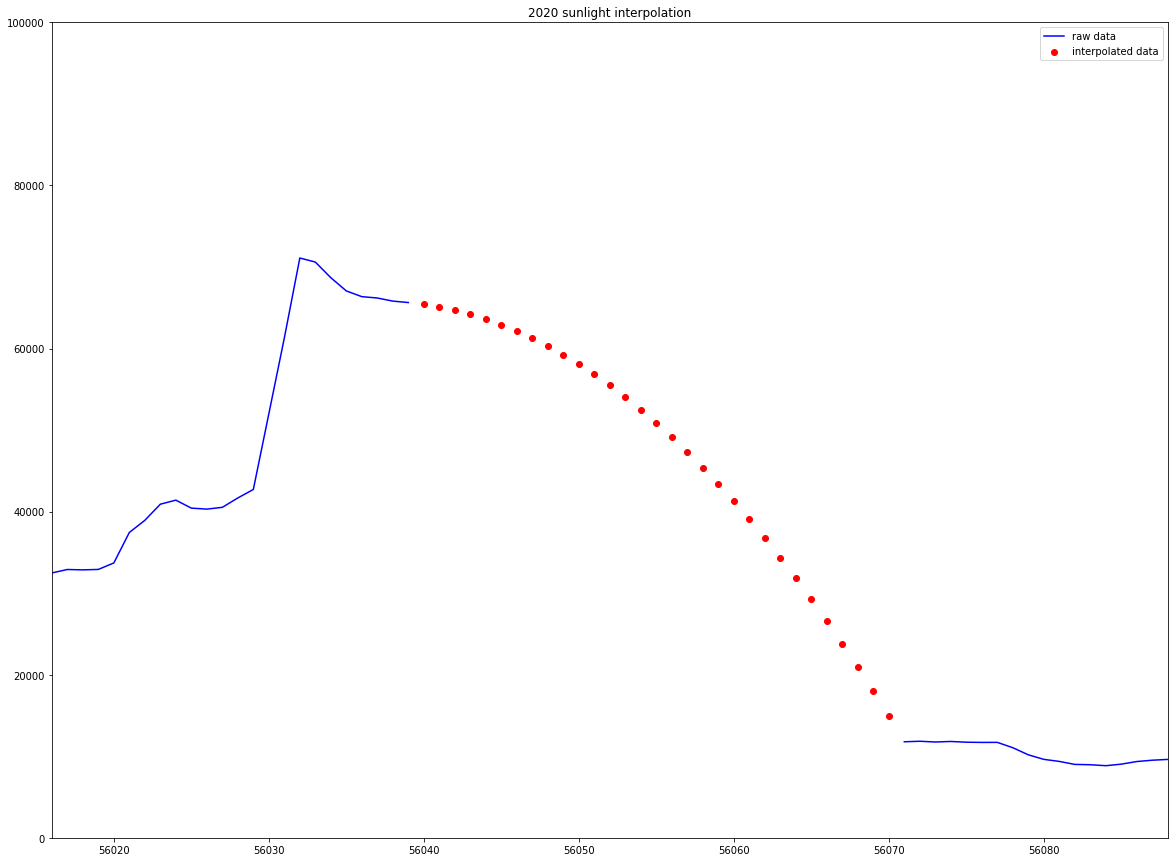

In [ ]:
show_num = 194
plt.figure(figsize=(20,15))
plt.title('2020 sunlight interpolation')
plt.plot(df_5m_2020_toshow['sunlight'], c = 'b', label = 'raw data')
plt.scatter(listnull_2020, int_show, c = 'r', label = 'interpolated data')
plt.xlim(0+show_num*12*24+12*12,12*24+show_num*12*24-12*6)
plt.ylim(0,100000)
plt.legend()
